In [24]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [25]:
_time_intervals = 30  # Number of time intervals in a planning horizon
_coms = 1
_exec_scenarios = 6  # Number of execution scenarios
M = 1e3  # Big M

init = [1]

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.58, 0.54, 0.07, 0.69, 0.17, 0.53, 0.35, 0.48, 0.39, 0.51, 0.38]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.26, 0.66, 0.28, 0.65, 0.01, 0.49, 0.39, 0.61, 0.44, 0.3, 0.68]})

loc6_varying_factor = pandas.DataFrame(data={'com1_process': [0]*6})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})

# Define temporal scales
scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])

In [26]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=125, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [27]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=75, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, prod_min=75,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, prod_min=M,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=150, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=150, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=150, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=150, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=150, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=150, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=150, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=150, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.1, prod_min=150, varying=[VaryingProcess.DETERMINISTIC_CAPACITY],
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=150, capex=100, vopex=1, store_min=0.01, store_max= 10, prod_min=150,
                  label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)

com1_store20 = Process(name='com1_store20', prod_max=150, capex=200, vopex=2, store_min=0.01,store_max= 20, prod_min=150,
                  label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)

com1_store50 = Process(name='com1_store50', prod_max=150, capex=500, vopex=5, store_min=0.01, store_max= 50, prod_min=150,
                  label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=150, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=150, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=50, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, prod_min=50,
                            label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=150, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=150, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=150, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=150, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, prod_min=150,
                            label='Send commodity one from location 7')

In [28]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, capacity_factor={com1_process: loc6_varying_factor[['com1_process']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

In [29]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=70, label='Truck capacity of 50 units from location 1 to 2', capex=0.5, vopex=0.05, trans_min=50)
truck50_21 = Transport(name='truck50_21', resources={com1_loc2_out}, trans_max=70, label='Truck capacity of 50 units from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=50)

truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=50, label='Truck capacity of 30 units from location 1 to 3', capex=0.3, vopex=0.03, trans_min=30)
truck30_31 = Transport(name='truck30_31', resources={com1_loc3_out}, trans_max=50, label='Truck capacity of 30 units from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=30)

truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 4', capex=0.5, vopex=0.05, trans_min=50)
truck50_42 = Transport(name='truck50_42', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=50)

truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck capacity of 30 units from location 2 to 5', capex=0.3, vopex=0.03, trans_min=30)
truck30_52 = Transport(name='truck30_52', resources={com1_loc5_out}, trans_max=30, label='Truck capacity of 30 units from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=30)

truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck capacity of 20 units from location 3 to 4', capex=0.2, vopex=0.02, trans_min=20)
truck20_43 = Transport(name='truck20_43', resources={com1_loc4_out}, trans_max=20, label='Truck capacity of 20 units from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=20)

truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 100 units from location 4 to 5', capex=1, vopex=0.1, trans_min=100)
truck100_54 = Transport(name='truck100_54', resources={com1_loc5_out}, trans_max=100, label='Truck capacity of 100 units from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=100)

truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck capacity of 40 units from location 4 to 7', capex=0.4, vopex=0.04, trans_min=40)
truck40_74 = Transport(name='truck40_74', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=40)

truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck capacity of 50 units from location 6 to 4', capex=0.5, vopex=0.05, trans_min=50)
truck50_46 = Transport(name='truck50_46', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=50)

truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 5', capex=0.4, vopex=0.04, trans_min=40)
truck40_57 = Transport(name='truck40_57', resources={com1_loc5_out}, trans_max=40, label='Truck capacity of 40 units from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=40)

In [30]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
    [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [31]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty = 5000
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_node_IS6 = Scenario(name='scenario_node_IS6', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=0, demand_scale_level=1, capacity_scale_level=0,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Scenario for information sharing after 6 periodswith node variability', annualization_factor=1/12)

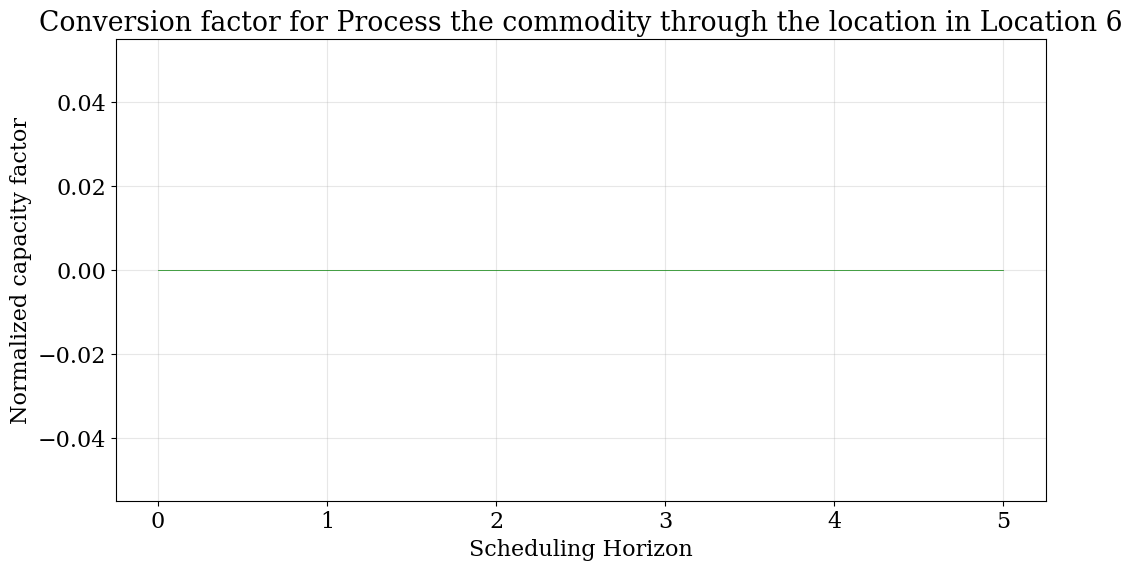

In [32]:
plot_scenario.capacity_factor(scenario=scenario_node_IS6, process=com1_process, location=loc6, color='green')

In [33]:
inventory6 = {loc1.name: {com1_store20.resource_storage.name: 0.0},
 loc2.name: {com1_store20.resource_storage.name: 0.0},
 loc3.name: {com1_store20.resource_storage.name: 0.0},
 loc4.name: {com1_store50.resource_storage.name: 0.0},
 loc5.name: {com1_store50.resource_storage.name: 0.0},
 loc6.name: {com1_store10.resource_storage.name: 0.0},
 loc7.name: {com1_store20.resource_storage.name: 0.0}}

dict_ = {i.name: {j: 0 for j in scenario_node_IS6.set_dict['resources_store']} for i in scenario_node_IS6.location_set}

for i in inventory6.keys():
    for j in inventory6[i].keys():
        dict_[i][j] = inventory6[i][j]

inventory6 = dict_

In [34]:
problem_mincost = formulate(scenario=scenario_node_IS6,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY, inventory_zero=inventory6)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint demand penalty
objective cost w demand penalty


In [35]:
results_mincost = solve(scenario=scenario_node_IS6, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 501978 rows, 1433191 columns and 696063 nonzeros
Model fingerprint: 0x3ec85c3f
Coefficient statistics:
  Matrix range     [5e-04, 4e+01]
  Objective range  [1e+00, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]
Presolve removed 497838 rows and 1425073 columns
Presolve time: 2.63s
Presolved: 4140 rows, 8118 columns, 17081 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.835e+04
 Factor NZ  : 1.283e+05 (roughly 6 MB of memory)
 Factor Ops : 5.914e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Prim

In [36]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') / (100*_exec_scenarios*_time_intervals)

0.75

In [37]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

75.0

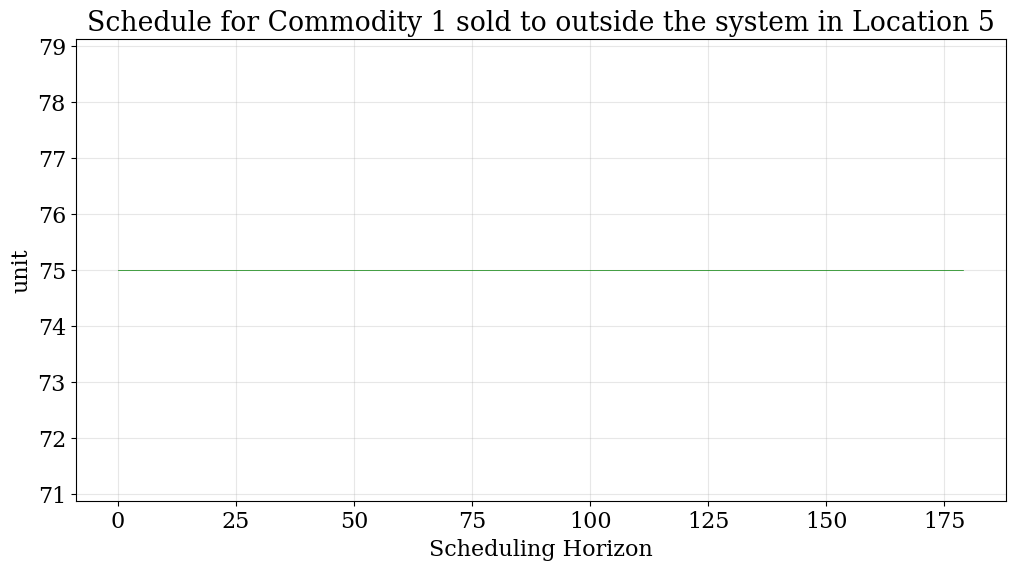

In [38]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

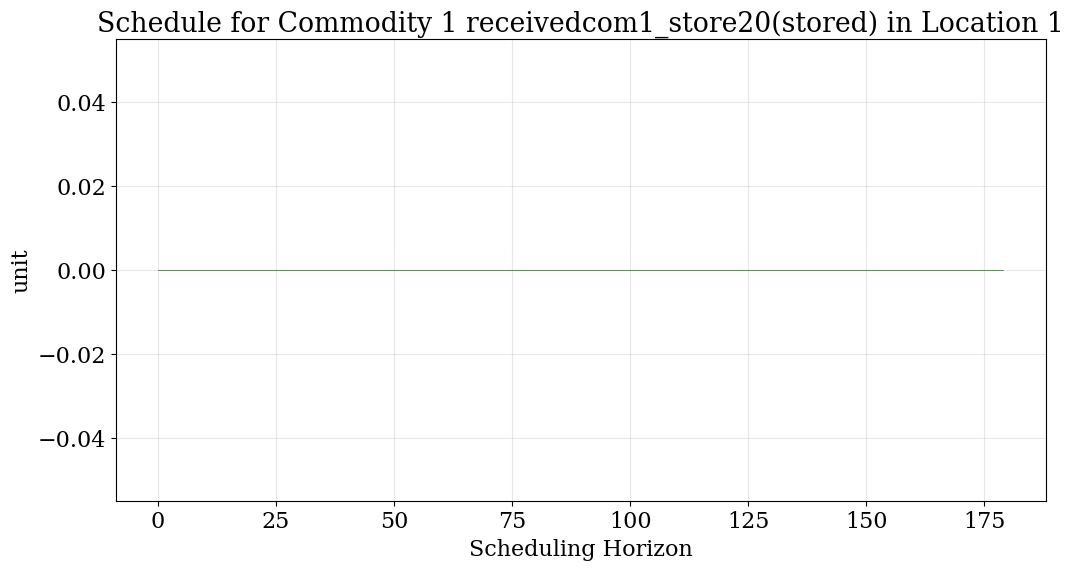

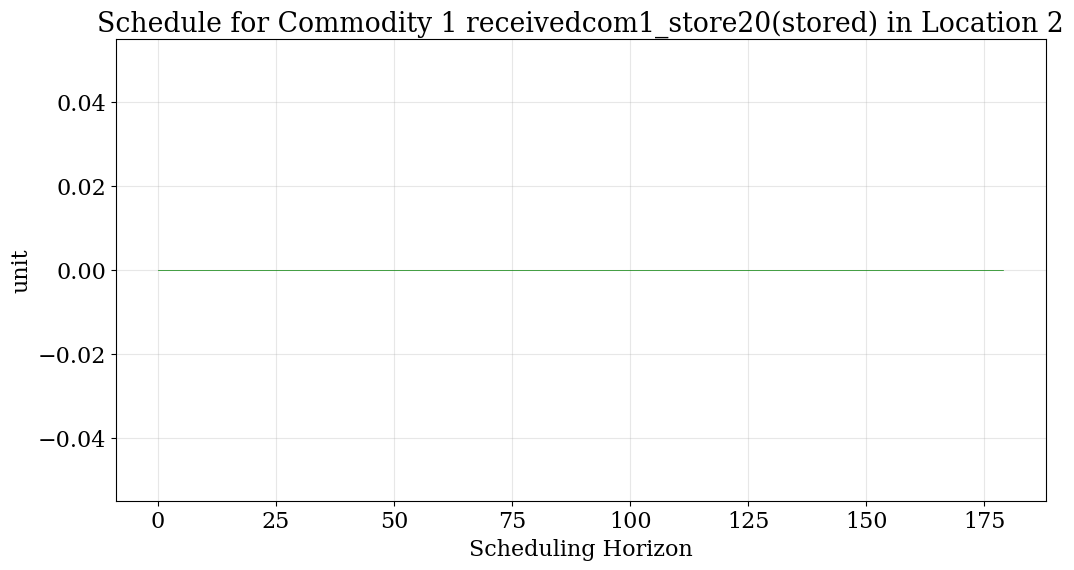

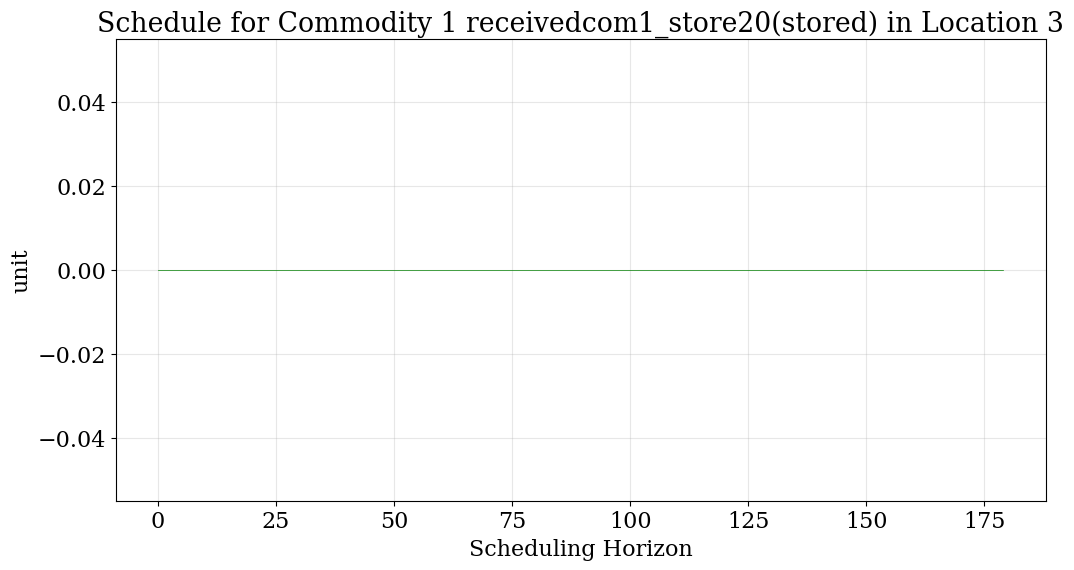

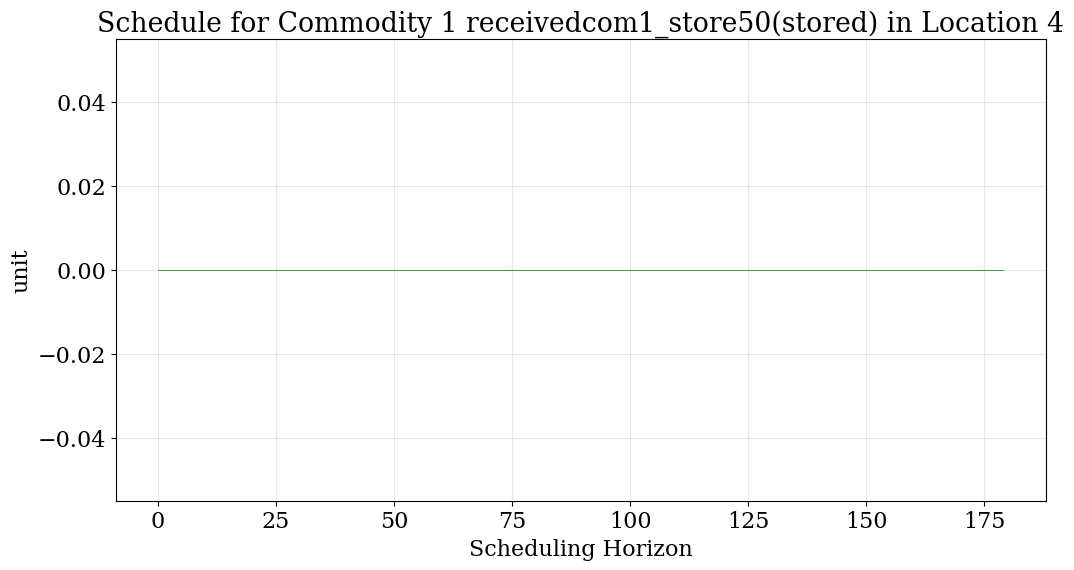

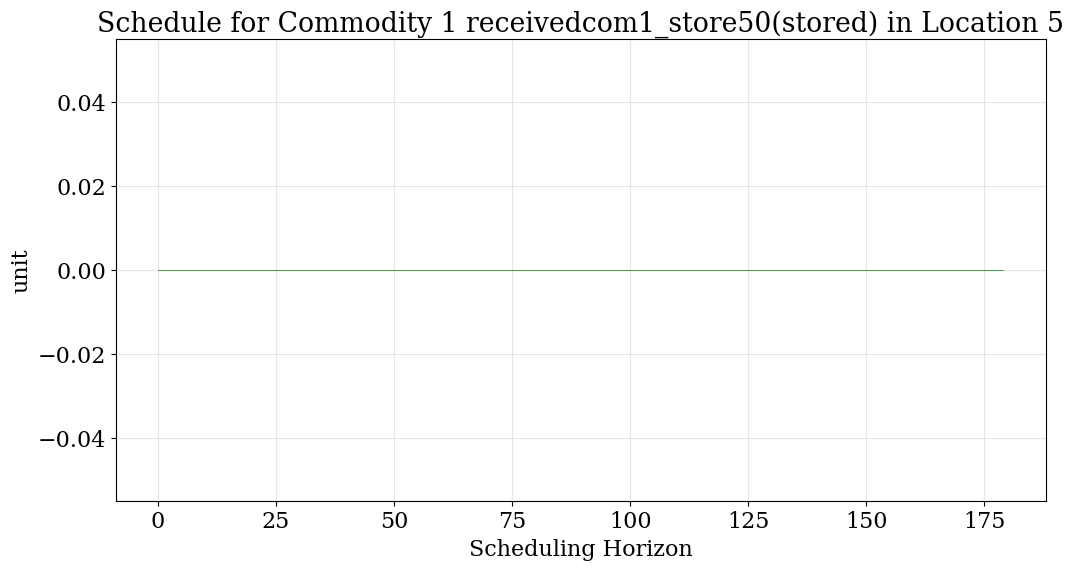

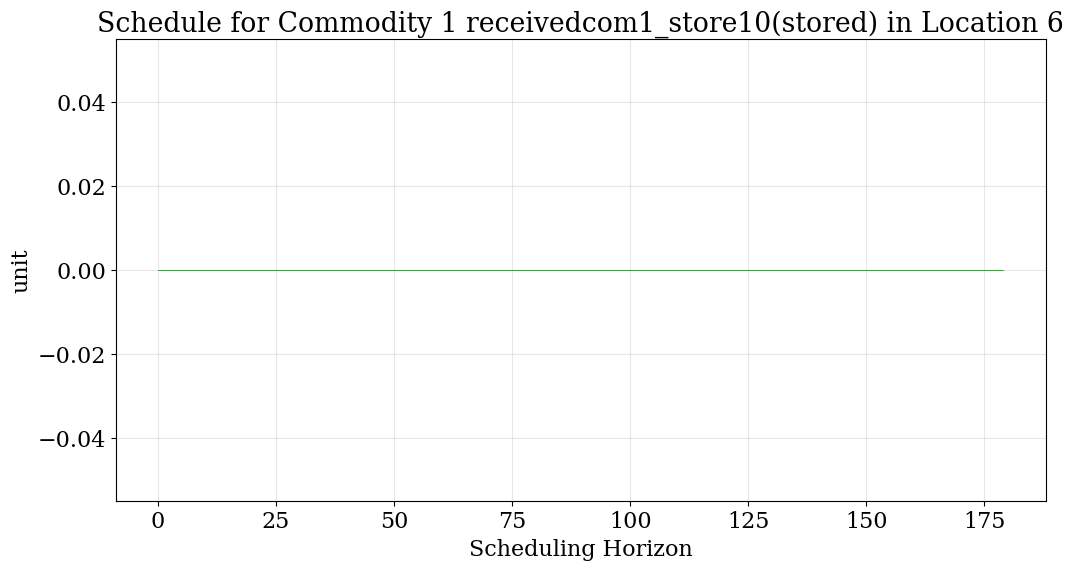

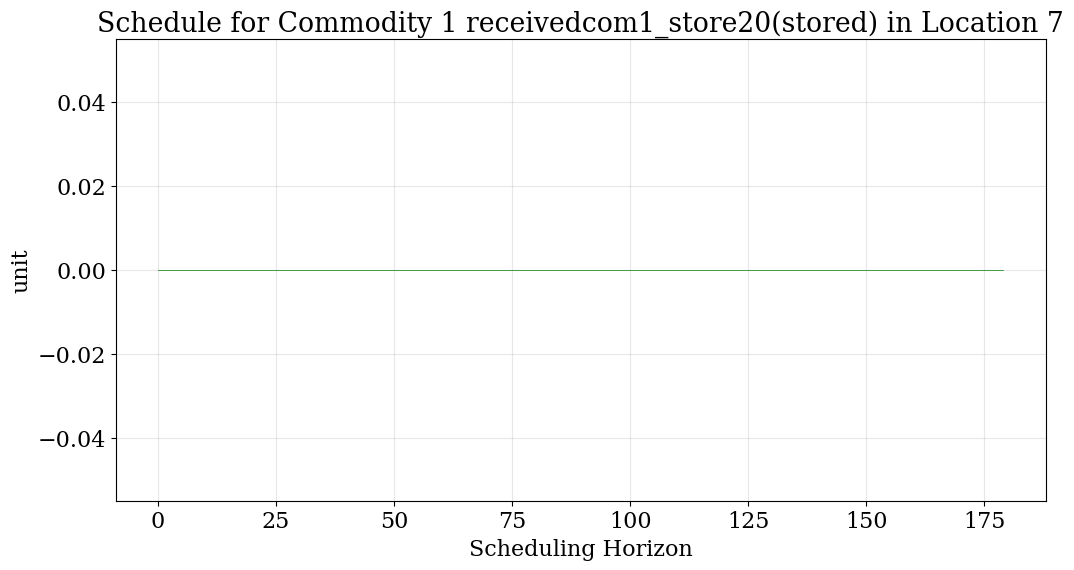

In [39]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

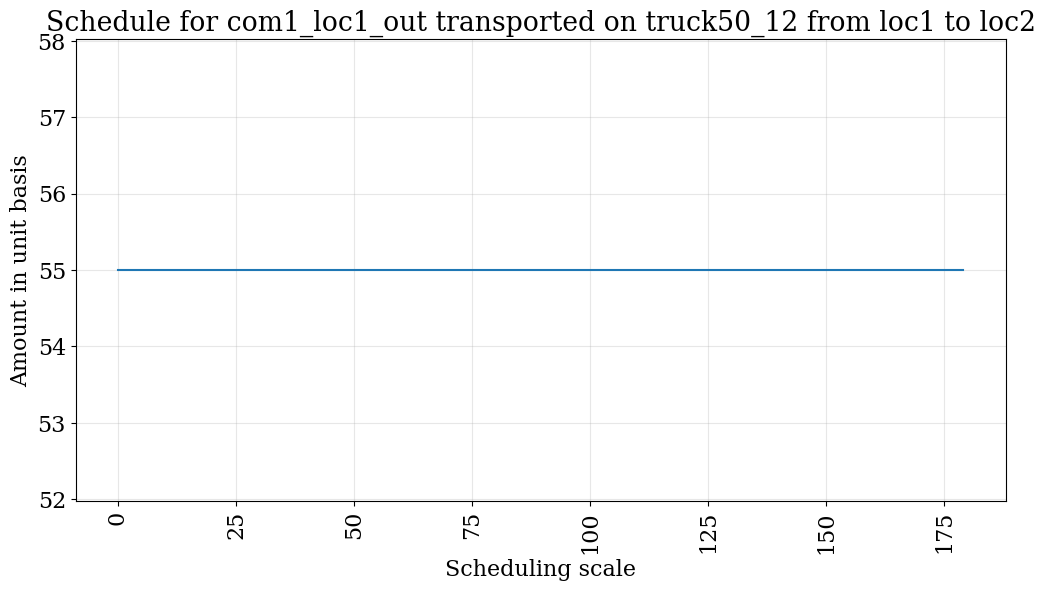

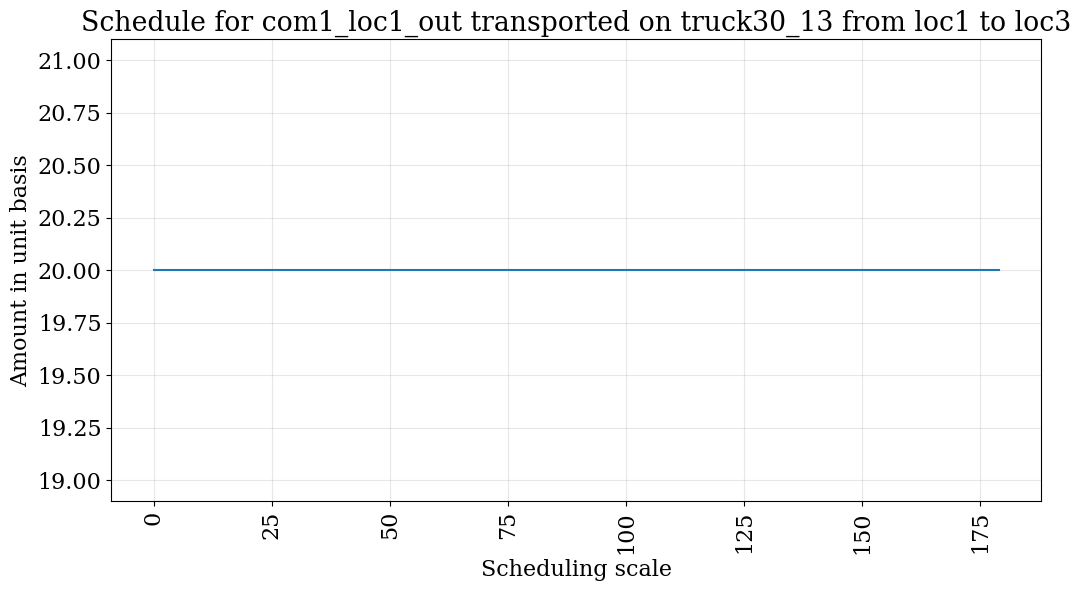

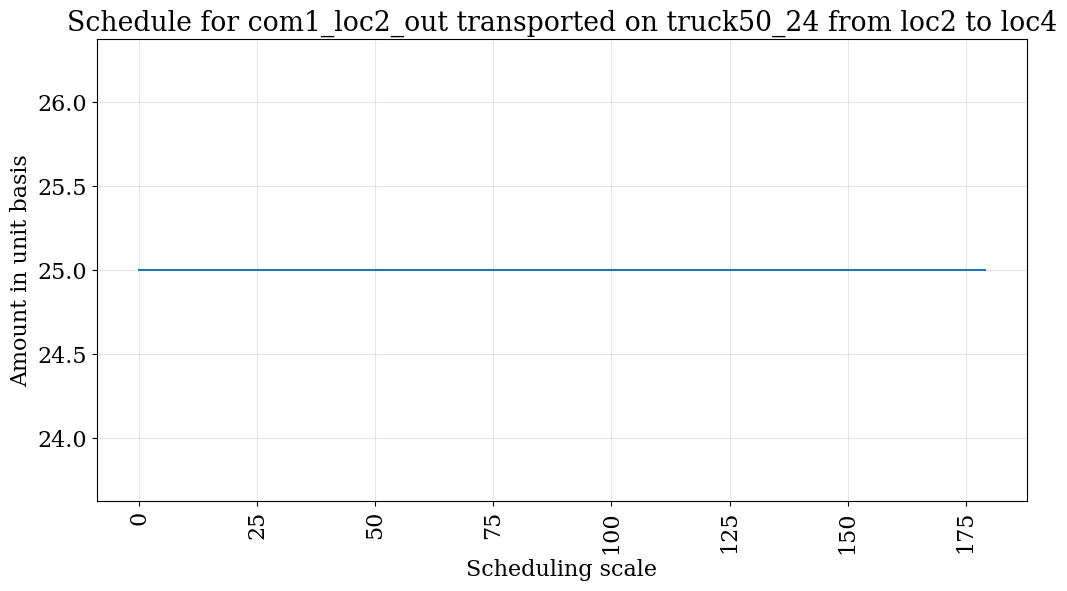

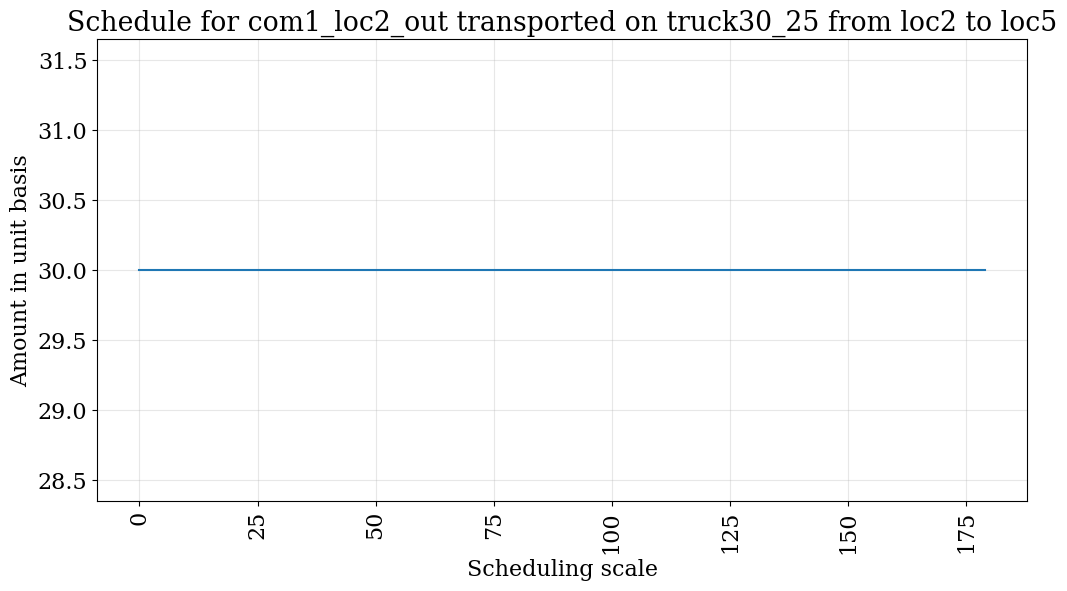

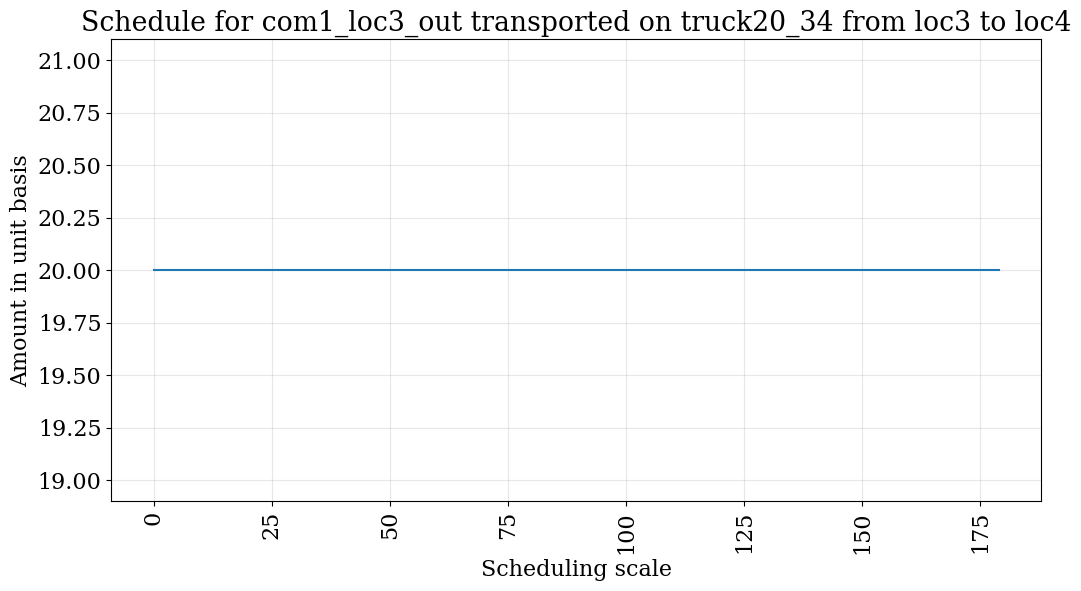

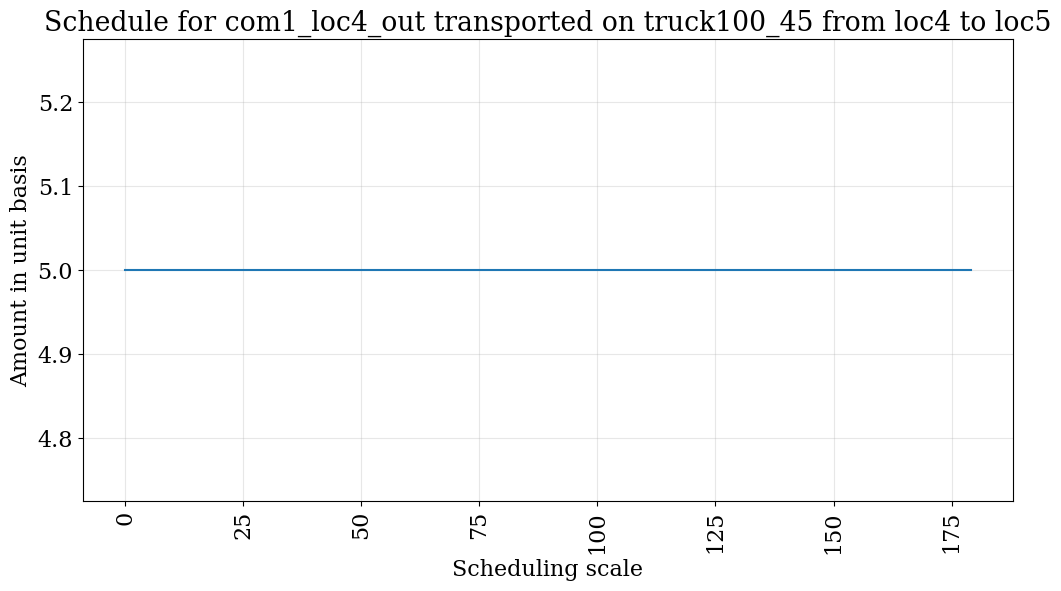

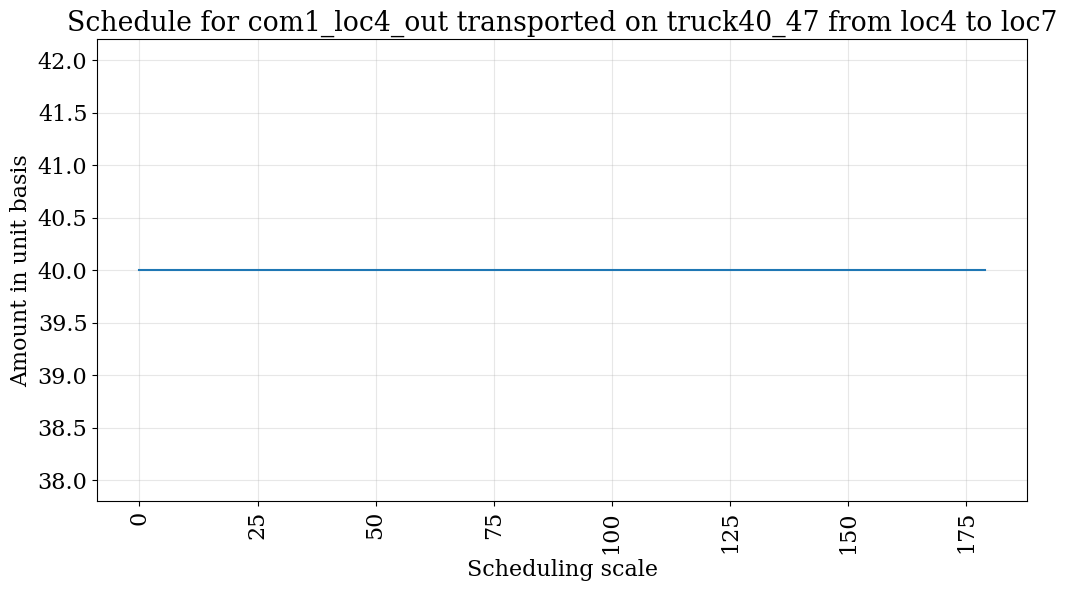

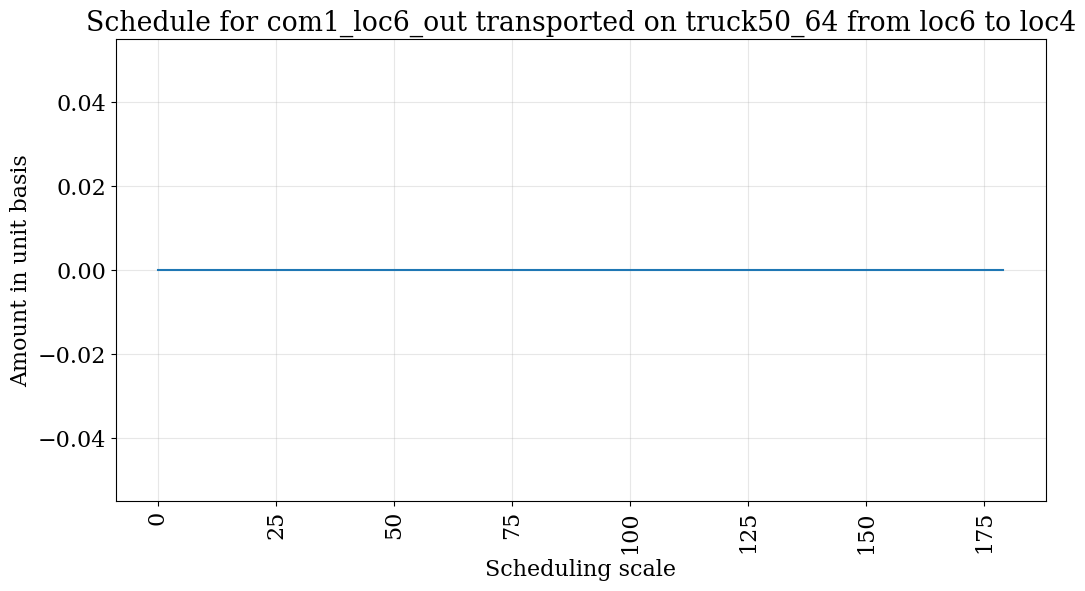

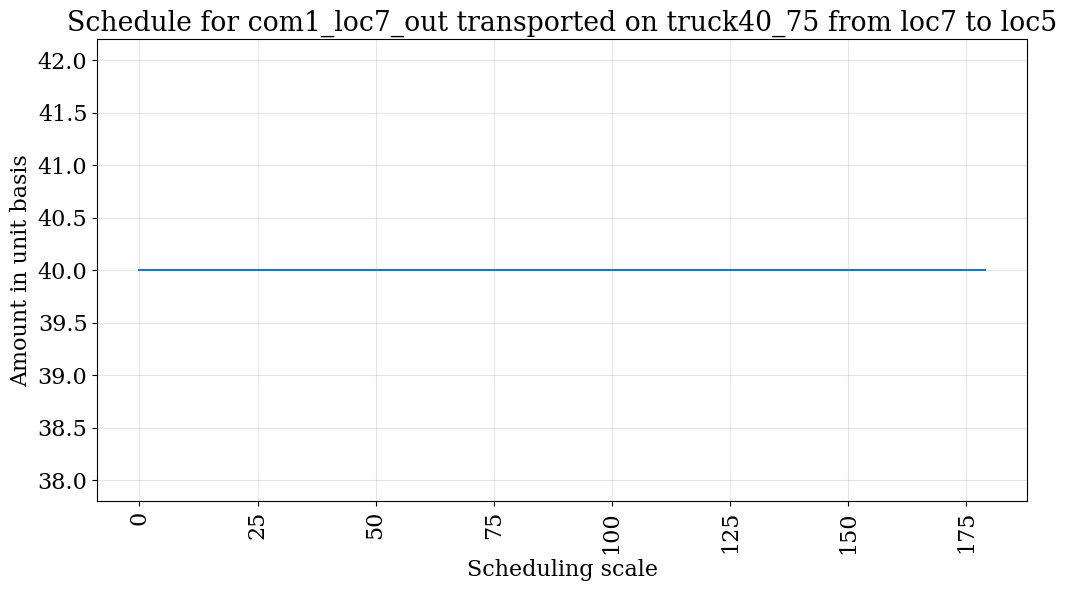

In [40]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck50_24',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
                       resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
                       resource='com1_loc7_out')

In [41]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()

Capex_network : Capex at network scale
    Size=6, Index=scales_network
    Key : Lower : Value    : Upper : Fixed : Stale : Domain
      0 :     0 : 23798.75 :  None : False : False : NonNegativeReals
      1 :     0 : 23798.75 :  None : False : False : NonNegativeReals
      2 :     0 : 23798.75 :  None : False : False : NonNegativeReals
      3 :     0 : 23798.75 :  None : False : False : NonNegativeReals
      4 :     0 : 23798.75 :  None : False : False : NonNegativeReals
      5 :     0 : 23798.75 :  None : False : False : NonNegativeReals
Fopex_network : Fixed Opex at network scale
    Size=6, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False : False : NonNegativeReals
      1 :     0 :   0.0 :  None : False : False : NonNegativeReals
      2 :     0 :   0.0 :  None : False : False : NonNegativeReals
      3 :     0 :   0.0 :  None : False : False : NonNegativeReals
      4 :     0 :   0.0 :  None : False : Fals

In [42]:
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()

Capex_transport_network : overall capex for transport at the network level
    Size=6, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 2049.4219166666667 :  None : False : False : NonNegativeReals
      1 :     0 : 2049.4219166666667 :  None : False : False : NonNegativeReals
      2 :     0 : 2049.4219166666667 :  None : False : False : NonNegativeReals
      3 :     0 : 2049.4219166666667 :  None : False : False : NonNegativeReals
      4 :     0 : 2049.4219166666667 :  None : False : False : NonNegativeReals
      5 :     0 : 2049.4219166666667 :  None : False : False : NonNegativeReals
Fopex_transport_network : overall fopex for transport at the network level
    Size=6, Index=scales_network
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   0.0 :  None : False : False : NonNegativeReals
      1 :     0 :   0.0 :  None : False : False : NonNegativeReals
      2 :     0 :   0.0 :  None : False : F

In [43]:
results_mincost.output[('objective')]

22852063.0315

In [44]:
total_cost = sum(value for key, value in results_mincost.output['Capex_network'].items()) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items())*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items())

total_cost

22852063.0315

In [45]:
sum(value for key, value in results_mincost.output['Inv_cost'].items())

0.0

In [46]:
vopex_cost = sum(value for key, value in results_mincost.output['Vopex_network'].items()) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items()) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items())*demand_penalty + \
sum(value for key, value in results_mincost.output['Inv_cost'].items())

vopex_cost

22696974.0

In [48]:
246024.0 + vopex_cost

22942998.0

In [47]:
# 401044.2815 + results_mincost.output['objective']

In [50]:
(sum(value for key, value in results_mincost.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold') + 18000)/36000

0.875